In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-03-20 13:00:35.235637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 13:00:35.783988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64::/home/joel/anaconda3/lib/
2023-03-20 13:00:35.784528: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/

## Data augmentation

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=30,var1_u=60,CROP1=CROP,BATCH_SIZE=50)

2023-03-20 13:00:41.161133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 13:00:41.166239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 13:00:41.166460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 13:00:41.166930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [3]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

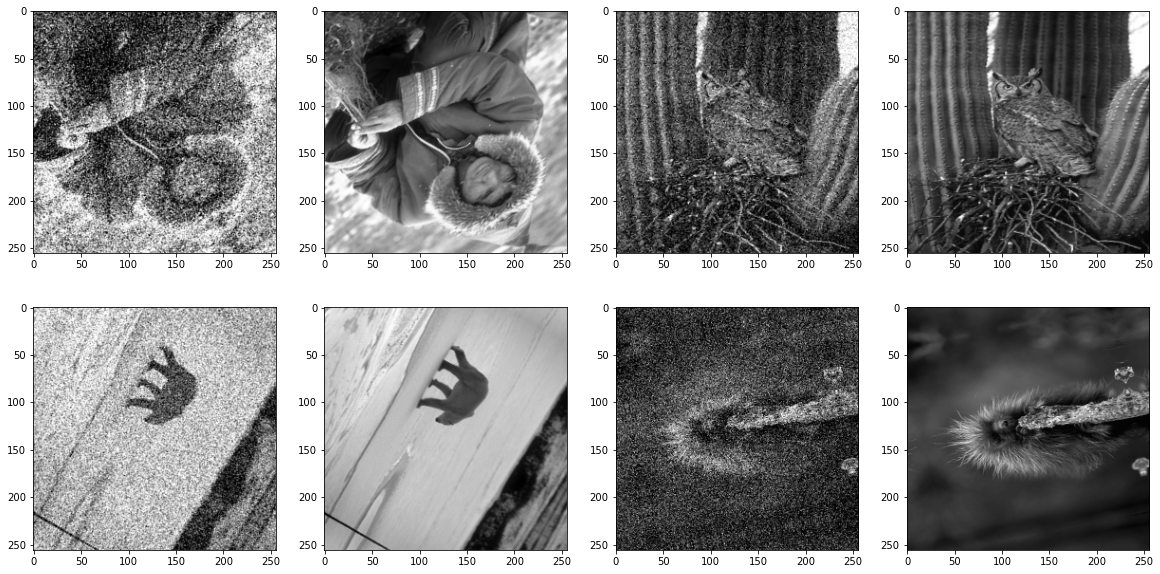

In [4]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()

# Neural networks

In [8]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

## Training

In [5]:
def loss(y_true,y_pred):
    return -tf.image.psnr(y_true,y_pred,1)

In [8]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)
    model = get_model("convex",it_lim=3,image_size=image_size,num_classes = num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss=loss,)
    #model.load_weights(f"./checkpoints/dec_{typ}_{num_classes}")
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/convex_{typ}_{num_classes}",
    save_weights_only=True,
    verbose = True,
    save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5)
    ]
    
    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
    
    np.save(f'./history/convex_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

num_classes:  15
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: -21.9012
Epoch 1: val_loss improved from inf to -23.46696, saving model to ./checkpoints/convex_gaussian_15
30/30 [==============================] - 17s 333ms/step - loss: -21.9012 - val_loss: -23.4670 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: -24.2537
Epoch 2: val_loss did not improve from -23.46696
30/30 [==============================] - 9s 312ms/step - loss: -24.2537 - val_loss: -23.3014 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: -24.4859
Epoch 3: val_loss did not improve from -23.46696
30/30 [==============================] - 9s 306ms/step - loss: -24.4859 - val_loss: -23.4105 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: -25.6969
Epoch 4: val_loss improved from -23.46696 to -23.87861, saving model to ./checkpoints/convex_gaussian_15
30/30 [==============================] - 8s 286ms/step


Epoch 32: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
30/30 [==============================] - 8s 259ms/step - loss: -26.8134 - val_loss: -26.5808 - lr: 2.0000e-04
Epoch 33/50
30/30 [==============================] - ETA: 0s - loss: -26.8319
Epoch 33: val_loss did not improve from -26.90654
30/30 [==============================] - 8s 259ms/step - loss: -26.8319 - val_loss: -26.8226 - lr: 4.0000e-05
Epoch 34/50
30/30 [==============================] - ETA: 0s - loss: -26.9772
Epoch 34: val_loss did not improve from -26.90654
30/30 [==============================] - 8s 258ms/step - loss: -26.9772 - val_loss: -26.8067 - lr: 4.0000e-05
Epoch 35/50
30/30 [==============================] - ETA: 0s - loss: -26.6634
Epoch 35: val_loss improved from -26.90654 to -26.90937, saving model to ./checkpoints/convex_gaussian_15
30/30 [==============================] - 8s 267ms/step - loss: -26.6634 - val_loss: -26.9094 - lr: 4.0000e-05
Epoch 36/50
30/30 [======================

Epoch 14/50
30/30 [==============================] - ETA: 0s - loss: -26.3388
Epoch 14: val_loss did not improve from -26.00168
30/30 [==============================] - 8s 266ms/step - loss: -26.3388 - val_loss: -25.1209 - lr: 0.0010
Epoch 15/50
30/30 [==============================] - ETA: 0s - loss: -25.2989
Epoch 15: val_loss did not improve from -26.00168
30/30 [==============================] - 8s 265ms/step - loss: -25.2989 - val_loss: -24.3891 - lr: 0.0010
Epoch 16/50
30/30 [==============================] - ETA: 0s - loss: -26.1962
Epoch 16: val_loss improved from -26.00168 to -26.34229, saving model to ./checkpoints/convex_gaussian_20
30/30 [==============================] - 8s 275ms/step - loss: -26.1962 - val_loss: -26.3423 - lr: 0.0010
Epoch 17/50
30/30 [==============================] - ETA: 0s - loss: -26.1478
Epoch 17: val_loss did not improve from -26.34229
30/30 [==============================] - 8s 265ms/step - loss: -26.1478 - val_loss: -25.9673 - lr: 0.0010
Epoch 18

30/30 [==============================] - 8s 263ms/step - loss: -26.7013 - val_loss: -26.7627 - lr: 1.6000e-06
Epoch 47/50
30/30 [==============================] - ETA: 0s - loss: -26.9769
Epoch 47: val_loss did not improve from -27.10265
30/30 [==============================] - 8s 266ms/step - loss: -26.9769 - val_loss: -26.9885 - lr: 3.2000e-07
Epoch 48/50
30/30 [==============================] - ETA: 0s - loss: -26.9302
Epoch 48: val_loss improved from -27.10265 to -27.13030, saving model to ./checkpoints/convex_gaussian_20
30/30 [==============================] - 8s 271ms/step - loss: -26.9302 - val_loss: -27.1303 - lr: 3.2000e-07
Epoch 49/50
30/30 [==============================] - ETA: 0s - loss: -26.9063
Epoch 49: val_loss improved from -27.13030 to -27.19121, saving model to ./checkpoints/convex_gaussian_20
30/30 [==============================] - 8s 271ms/step - loss: -26.9063 - val_loss: -27.1912 - lr: 3.2000e-07
Epoch 50/50
30/30 [==============================] - ETA: 0s - l

30/30 [==============================] - 12s 418ms/step - loss: -23.8951 - val_loss: -24.7807 - lr: 2.0000e-04
Epoch 28/50
30/30 [==============================] - ETA: 0s - loss: -24.5012
Epoch 28: val_loss did not improve from -26.53794
30/30 [==============================] - 12s 417ms/step - loss: -24.5012 - val_loss: -24.5214 - lr: 4.0000e-05
Epoch 29/50
30/30 [==============================] - ETA: 0s - loss: -24.8934
Epoch 29: val_loss did not improve from -26.53794
30/30 [==============================] - 12s 418ms/step - loss: -24.8934 - val_loss: -24.7941 - lr: 4.0000e-05
Epoch 30/50
30/30 [==============================] - ETA: 0s - loss: -24.6999
Epoch 30: val_loss did not improve from -26.53794
30/30 [==============================] - 12s 419ms/step - loss: -24.6999 - val_loss: -24.9814 - lr: 4.0000e-05
Epoch 31/50
30/30 [==============================] - ETA: 0s - loss: -24.5685
Epoch 31: val_loss did not improve from -26.53794
30/30 [==============================] - 12s

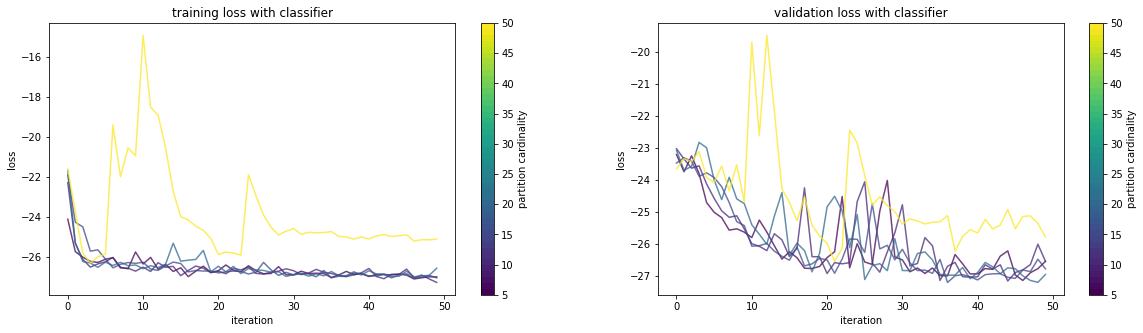

In [9]:
trained = glob(f'./history/convex_*')
w = [int(i.split('_')[-1].split('.')[0]) for i in trained]
n = len(trained)+1
viridis = cm.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, np.amax(w)-np.amin(w)+1))
newcmp = ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols=2,figsize=(20,5))

for j,i in enumerate(trained):
    
    v = np.load(i)
    axs[0].plot(v[0],alpha=0.75,color = colors[w[j]-np.amin(w)])
    axs[1].plot(v[1],alpha=0.75,color = colors[w[j]-np.amin(w)])
    
axs[0].set_title("training loss with classifier")
axs[1].set_title("validation loss with classifier")

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[0],label='partition cardinality')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[1],label='partition cardinality')
    
plt.show()



In [8]:
def loss(y_true,y_pred):
    error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))
    error = -10*tf.experimental.numpy.log10(1/error)
    return error


typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)

    model = get_model("convex",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")


    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/convexLinfty_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
        
            

  
    np.save(f'./history/convexLinfty_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

num_classes:  5
Epoch 1/50


2023-03-18 17:40:23.487937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-18 17:40:24.537164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-18 17:40:24.579656: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f13a224e290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-18 17:40:24.579668: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-03-18 17:40:24.579674: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2023-03-18 17:40:24.582613: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-18 17:40:24.67302

Batch 0: Invalid loss, terminating training
 1/30 [>.............................] - ETA: 4:42 - loss: inf
Epoch 1: val_loss did not improve from inf
30/30 [==============================] - 13s 96ms/step - loss: inf - val_loss: nan - lr: 1.0000e-04
num_classes:  10
Epoch 1/50
Batch 0: Invalid loss, terminating training
 1/30 [>.............................] - ETA: 3:29 - loss: inf
Epoch 1: val_loss did not improve from inf
30/30 [==============================] - 10s 94ms/step - loss: inf - val_loss: nan - lr: 1.0000e-04
num_classes:  15
Epoch 1/50
Batch 0: Invalid loss, terminating training
 1/30 [>.............................] - ETA: 3:32 - loss: inf
Epoch 1: val_loss did not improve from inf
30/30 [==============================] - 10s 95ms/step - loss: inf - val_loss: nan - lr: 1.0000e-04
num_classes:  20
Epoch 1/50
Batch 0: Invalid loss, terminating training
 1/30 [>.............................] - ETA: 3:25 - loss: inf
Epoch 1: val_loss did not improve from inf
30/30 [=========

In [9]:
def loss(y_true,y_pred):
    error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))
    
    dx_true,dy_true = tf.image.image_gradients(y_true)
    dx_pred,dy_pred = tf.image.image_gradients(y_pred)
    
    error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dx_true-dx_pred))))
    error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dy_true-dy_pred))))
    
    error = -10*tf.experimental.numpy.log10(1/error)
    
    return error


typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)

    model = get_model("convex",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")


    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/convexW1infty_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
        
            

  
    np.save(f'./history/convexW1infty_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

num_classes:  5
Epoch 1/50
Batch 0: Invalid loss, terminating training
 1/30 [>.............................] - ETA: 3:35 - loss: inf
Epoch 1: val_loss did not improve from inf
30/30 [==============================] - 10s 95ms/step - loss: inf - val_loss: nan - lr: 1.0000e-04
num_classes:  10
Epoch 1/50
Batch 0: Invalid loss, terminating training
 1/30 [>.............................] - ETA: 3:27 - loss: inf
Epoch 1: val_loss did not improve from inf
30/30 [==============================] - 10s 97ms/step - loss: inf - val_loss: nan - lr: 1.0000e-04
num_classes:  15
Epoch 1/50
Batch 0: Invalid loss, terminating training
 1/30 [>.............................] - ETA: 3:41 - loss: inf
Epoch 1: val_loss did not improve from inf
30/30 [==============================] - 10s 97ms/step - loss: inf - val_loss: nan - lr: 1.0000e-04
num_classes:  20
Epoch 1/50
Batch 0: Invalid loss, terminating training
 1/30 [>.............................] - ETA: 3:29 - loss: inf
Epoch 1: val_loss did not improv

In [10]:
def loss(y_true,y_pred):
    error = tf.math.reduce_mean(tf.pow(y_true-y_pred,2))
    
    dx_true,dy_true = tf.image.image_gradients(y_true)
    dx_pred,dy_pred = tf.image.image_gradients(y_pred)
    
    error += tf.math.reduce_mean(tf.pow(dx_true-dx_pred,2))
    error += tf.math.reduce_mean(tf.pow(dy_true-dy_pred,2))
    error = tf.sqrt(error)
    
    error = -10*tf.experimental.numpy.log10(1/error)
    
    return error


typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)

    model = get_model("convex",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")


    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/convexH1_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
        
            

  
    np.save(f'./history/convexH1_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

num_classes:  5
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: -5.3322
Epoch 1: val_loss improved from inf to -7.76479, saving model to ./checkpoints/convexH1_gaussian_5
30/30 [==============================] - 17s 328ms/step - loss: -5.3322 - val_loss: -7.7648 - lr: 1.0000e-04
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: -9.6332
Epoch 2: val_loss improved from -7.76479 to -7.76989, saving model to ./checkpoints/convexH1_gaussian_5
30/30 [==============================] - 9s 323ms/step - loss: -9.6332 - val_loss: -7.7699 - lr: 1.0000e-04
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: -10.2442
Epoch 3: val_loss did not improve from -7.76989
30/30 [==============================] - 9s 308ms/step - loss: -10.2442 - val_loss: -7.6983 - lr: 1.0000e-04
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: -10.2679
Epoch 4: val_loss improved from -7.76989 to -7.85668, saving model to ./checkpoints/convexH1_gaussian

30/30 [==============================] - 8s 267ms/step - loss: -10.5723 - val_loss: -10.3419 - lr: 1.0000e-04
Epoch 15/50
30/30 [==============================] - ETA: 0s - loss: -10.6070
Epoch 15: val_loss improved from -10.34186 to -10.45195, saving model to ./checkpoints/convexH1_gaussian_10
30/30 [==============================] - 8s 266ms/step - loss: -10.6070 - val_loss: -10.4519 - lr: 1.0000e-04
Epoch 16/50
30/30 [==============================] - ETA: 0s - loss: -10.6084
Epoch 16: val_loss improved from -10.45195 to -10.55426, saving model to ./checkpoints/convexH1_gaussian_10
30/30 [==============================] - 8s 264ms/step - loss: -10.6084 - val_loss: -10.5543 - lr: 1.0000e-04
Epoch 17/50
30/30 [==============================] - ETA: 0s - loss: -9.8890
Epoch 17: val_loss did not improve from -10.55426
30/30 [==============================] - 7s 252ms/step - loss: -9.8890 - val_loss: -10.0991 - lr: 1.0000e-04
Epoch 18/50
30/30 [==============================] - ETA: 0s -

30/30 [==============================] - ETA: 0s - loss: -10.7406
Epoch 28: val_loss did not improve from -10.67447
30/30 [==============================] - 7s 253ms/step - loss: -10.7406 - val_loss: -10.6441 - lr: 1.0000e-04
Epoch 29/50
30/30 [==============================] - ETA: 0s - loss: -10.7040
Epoch 29: val_loss did not improve from -10.67447
30/30 [==============================] - 8s 258ms/step - loss: -10.7040 - val_loss: -10.6263 - lr: 1.0000e-04
Epoch 30/50
30/30 [==============================] - ETA: 0s - loss: -10.6404
Epoch 30: val_loss improved from -10.67447 to -10.77196, saving model to ./checkpoints/convexH1_gaussian_15
30/30 [==============================] - 8s 271ms/step - loss: -10.6404 - val_loss: -10.7720 - lr: 1.0000e-04
Epoch 31/50
30/30 [==============================] - ETA: 0s - loss: -10.5997
Epoch 31: val_loss did not improve from -10.77196
30/30 [==============================] - 8s 257ms/step - loss: -10.5997 - val_loss: -10.5318 - lr: 1.0000e-04
Ep

30/30 [==============================] - 8s 272ms/step - loss: -10.5359 - val_loss: -8.3988 - lr: 1.0000e-04
Epoch 11/50
30/30 [==============================] - ETA: 0s - loss: -10.4751
Epoch 11: val_loss improved from -8.39884 to -8.50747, saving model to ./checkpoints/convexH1_gaussian_20
30/30 [==============================] - 8s 272ms/step - loss: -10.4751 - val_loss: -8.5075 - lr: 1.0000e-04
Epoch 12/50
30/30 [==============================] - ETA: 0s - loss: -10.6247
Epoch 12: val_loss improved from -8.50747 to -8.97476, saving model to ./checkpoints/convexH1_gaussian_20
30/30 [==============================] - 8s 271ms/step - loss: -10.6247 - val_loss: -8.9748 - lr: 1.0000e-04
Epoch 13/50
30/30 [==============================] - ETA: 0s - loss: -10.6002
Epoch 13: val_loss improved from -8.97476 to -9.24290, saving model to ./checkpoints/convexH1_gaussian_20
30/30 [==============================] - 8s 273ms/step - loss: -10.6002 - val_loss: -9.2429 - lr: 1.0000e-04
Epoch 14/50


30/30 [==============================] - 8s 266ms/step - loss: -10.6893 - val_loss: -10.7284 - lr: 2.0000e-05
Epoch 43/50
30/30 [==============================] - ETA: 0s - loss: -10.6961
Epoch 43: val_loss did not improve from -10.82461
30/30 [==============================] - 8s 266ms/step - loss: -10.6961 - val_loss: -10.5724 - lr: 2.0000e-05
Epoch 44/50
30/30 [==============================] - ETA: 0s - loss: -10.6660
Epoch 44: val_loss did not improve from -10.82461
30/30 [==============================] - 8s 263ms/step - loss: -10.6660 - val_loss: -10.1910 - lr: 2.0000e-05
Epoch 45/50
30/30 [==============================] - ETA: 0s - loss: -10.7553
Epoch 45: val_loss did not improve from -10.82461
30/30 [==============================] - 8s 265ms/step - loss: -10.7553 - val_loss: -10.7074 - lr: 2.0000e-05
Epoch 46/50
30/30 [==============================] - ETA: 0s - loss: -10.6947
Epoch 46: val_loss did not improve from -10.82461
30/30 [==============================] - 8s 265m

Epoch 24/50
30/30 [==============================] - ETA: 0s - loss: -10.6568
Epoch 24: val_loss did not improve from -10.75946
30/30 [==============================] - 12s 419ms/step - loss: -10.6568 - val_loss: -10.6739 - lr: 2.0000e-05
Epoch 25/50
30/30 [==============================] - ETA: 0s - loss: -10.5979
Epoch 25: val_loss did not improve from -10.75946
30/30 [==============================] - 13s 420ms/step - loss: -10.5979 - val_loss: -10.5928 - lr: 2.0000e-05
Epoch 26/50
30/30 [==============================] - ETA: 0s - loss: -10.7025
Epoch 26: val_loss did not improve from -10.75946
30/30 [==============================] - 13s 420ms/step - loss: -10.7025 - val_loss: -10.5634 - lr: 2.0000e-05
Epoch 27/50
30/30 [==============================] - ETA: 0s - loss: -10.6819
Epoch 27: val_loss did not improve from -10.75946
30/30 [==============================] - 12s 419ms/step - loss: -10.6819 - val_loss: -10.7352 - lr: 2.0000e-05
Epoch 28/50
30/30 [=========================

In [11]:
def loss(y_true,y_pred):
    error = -tf.image.ssim(y_true,y_pred,1)  
    return error


typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)

    model = get_model("convex",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")


    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/convexprobabilty_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
        
            

  
    np.save(f'./history/convexprobability_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

num_classes:  5
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: -0.2938
Epoch 1: val_loss improved from inf to -0.52981, saving model to ./checkpoints/convexprobabilty_gaussian_5
30/30 [==============================] - 17s 336ms/step - loss: -0.2938 - val_loss: -0.5298 - lr: 1.0000e-04
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: -0.6098
Epoch 2: val_loss improved from -0.52981 to -0.55409, saving model to ./checkpoints/convexprobabilty_gaussian_5
30/30 [==============================] - 9s 319ms/step - loss: -0.6098 - val_loss: -0.5541 - lr: 1.0000e-04
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: -0.6640
Epoch 3: val_loss improved from -0.55409 to -0.58677, saving model to ./checkpoints/convexprobabilty_gaussian_5
30/30 [==============================] - 9s 308ms/step - loss: -0.6640 - val_loss: -0.5868 - lr: 1.0000e-04
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: -0.6740
Epoch 4: val_loss improv

Epoch 33/50
30/30 [==============================] - ETA: 0s - loss: -0.6974
Epoch 33: val_loss did not improve from -0.71548
30/30 [==============================] - 8s 261ms/step - loss: -0.6974 - val_loss: -0.6811 - lr: 1.0000e-04
Epoch 34/50
30/30 [==============================] - ETA: 0s - loss: -0.6944
Epoch 34: val_loss did not improve from -0.71548
30/30 [==============================] - 7s 255ms/step - loss: -0.6944 - val_loss: -0.6955 - lr: 1.0000e-04
Epoch 35/50
30/30 [==============================] - ETA: 0s - loss: -0.6989
Epoch 35: val_loss did not improve from -0.71548
30/30 [==============================] - 8s 259ms/step - loss: -0.6989 - val_loss: -0.6976 - lr: 1.0000e-04
Epoch 36/50
30/30 [==============================] - ETA: 0s - loss: -0.6893
Epoch 36: val_loss did not improve from -0.71548
30/30 [==============================] - 8s 258ms/step - loss: -0.6893 - val_loss: -0.6940 - lr: 1.0000e-04
Epoch 37/50
30/30 [==============================] - ETA: 0s - l

30/30 [==============================] - ETA: 0s - loss: -0.7009
Epoch 48: val_loss did not improve from -0.72519
30/30 [==============================] - 8s 256ms/step - loss: -0.7009 - val_loss: -0.7200 - lr: 4.0000e-06
Epoch 49/50
30/30 [==============================] - ETA: 0s - loss: -0.6959
Epoch 49: val_loss did not improve from -0.72519
30/30 [==============================] - 7s 254ms/step - loss: -0.6959 - val_loss: -0.7093 - lr: 4.0000e-06
Epoch 50/50
30/30 [==============================] - ETA: 0s - loss: -0.7029
Epoch 50: val_loss did not improve from -0.72519
30/30 [==============================] - 8s 261ms/step - loss: -0.7029 - val_loss: -0.7024 - lr: 4.0000e-06
num_classes:  15
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: -0.2346
Epoch 1: val_loss improved from inf to -0.49795, saving model to ./checkpoints/convexprobabilty_gaussian_15
30/30 [==============================] - 18s 332ms/step - loss: -0.2346 - val_loss: -0.4980 - lr: 1.0000e-04


Epoch 30/50
30/30 [==============================] - ETA: 0s - loss: -0.6911
Epoch 30: val_loss did not improve from -0.71889
30/30 [==============================] - 8s 260ms/step - loss: -0.6911 - val_loss: -0.7069 - lr: 2.0000e-05
Epoch 31/50
30/30 [==============================] - ETA: 0s - loss: -0.7045
Epoch 31: val_loss did not improve from -0.71889
30/30 [==============================] - 8s 261ms/step - loss: -0.7045 - val_loss: -0.7037 - lr: 2.0000e-05
Epoch 32/50
30/30 [==============================] - ETA: 0s - loss: -0.6974
Epoch 32: val_loss did not improve from -0.71889
30/30 [==============================] - 8s 259ms/step - loss: -0.6974 - val_loss: -0.7026 - lr: 2.0000e-05
Epoch 33/50
30/30 [==============================] - ETA: 0s - loss: -0.6901
Epoch 33: val_loss did not improve from -0.71889
30/30 [==============================] - 8s 256ms/step - loss: -0.6901 - val_loss: -0.7140 - lr: 2.0000e-05
Epoch 34/50
30/30 [==============================] - ETA: 0s - l

30/30 [==============================] - 8s 269ms/step - loss: -0.6885 - val_loss: -0.5406 - lr: 1.0000e-04
Epoch 13/50
30/30 [==============================] - ETA: 0s - loss: -0.6837
Epoch 13: val_loss improved from -0.54769 to -0.56929, saving model to ./checkpoints/convexprobabilty_gaussian_20
30/30 [==============================] - 8s 276ms/step - loss: -0.6837 - val_loss: -0.5693 - lr: 1.0000e-04
Epoch 14/50
30/30 [==============================] - ETA: 0s - loss: -0.6891
Epoch 14: val_loss did not improve from -0.56929
30/30 [==============================] - 8s 270ms/step - loss: -0.6891 - val_loss: -0.5641 - lr: 1.0000e-04
Epoch 15/50
30/30 [==============================] - ETA: 0s - loss: -0.6922
Epoch 15: val_loss improved from -0.56929 to -0.63152, saving model to ./checkpoints/convexprobabilty_gaussian_20
30/30 [==============================] - 8s 272ms/step - loss: -0.6922 - val_loss: -0.6315 - lr: 1.0000e-04
Epoch 16/50
30/30 [==============================] - ETA: 0s

30/30 [==============================] - ETA: 0s - loss: -0.4290
Epoch 27: val_loss did not improve from -inf
30/30 [==============================] - 13s 427ms/step - loss: -0.4290 - val_loss: -0.4858 - lr: 2.0000e-05
Epoch 28/50
30/30 [==============================] - ETA: 0s - loss: -0.4187
Epoch 28: val_loss did not improve from -inf
30/30 [==============================] - 13s 427ms/step - loss: -0.4187 - val_loss: -0.5098 - lr: 2.0000e-05
Epoch 29/50
30/30 [==============================] - ETA: 0s - loss: -0.4321
Epoch 29: val_loss did not improve from -inf
30/30 [==============================] - 13s 426ms/step - loss: -0.4321 - val_loss: -0.4727 - lr: 2.0000e-05
Epoch 30/50
30/30 [==============================] - ETA: 0s - loss: -0.4204
Epoch 30: val_loss did not improve from -inf
30/30 [==============================] - 13s 426ms/step - loss: -0.4204 - val_loss: -0.4605 - lr: 2.0000e-05
Epoch 31/50
30/30 [==============================] - ETA: 0s - loss: -0.4332
Epoch 31: v

## decreasing

In [5]:
def loss(y_true,y_pred):
    return -tf.image.psnr(y_true,y_pred,1)


typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)

    model = get_model("decreasing",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")


    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/decL2_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
        
            

  
    np.save(f'./history/decL2_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

num_classes:  5
Epoch 1/50


2023-03-20 13:00:57.583803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-20 13:00:58.610660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-20 13:00:58.640067: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55bdf6e66950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-20 13:00:58.640089: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-03-20 13:00:58.643792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-20 13:00:58.738113: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

30/30 [==============================] - ETA: 0s - loss: -22.6009
Epoch 1: val_loss improved from inf to -20.30189, saving model to ./checkpoints/decL2_gaussian_5
30/30 [==============================] - 20s 354ms/step - loss: -22.6009 - val_loss: -20.3019 - lr: 1.0000e-04
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: -22.6533
Epoch 2: val_loss improved from -20.30189 to -20.65234, saving model to ./checkpoints/decL2_gaussian_5
30/30 [==============================] - 9s 316ms/step - loss: -22.6533 - val_loss: -20.6523 - lr: 1.0000e-04
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: -22.7843
Epoch 3: val_loss did not improve from -20.65234
30/30 [==============================] - 9s 303ms/step - loss: -22.7843 - val_loss: -20.5795 - lr: 1.0000e-04
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: -22.7242
Epoch 4: val_loss did not improve from -20.65234
30/30 [==============================] - 8s 276ms/step - loss: -22.7242 - 

30/30 [==============================] - ETA: 0s - loss: -22.8571
Epoch 32: val_loss did not improve from -22.89344
30/30 [==============================] - 8s 259ms/step - loss: -22.8571 - val_loss: -22.5476 - lr: 1.0000e-04
Epoch 33/50
30/30 [==============================] - ETA: 0s - loss: -22.7759
Epoch 33: val_loss did not improve from -22.89344
30/30 [==============================] - 8s 266ms/step - loss: -22.7759 - val_loss: -22.5355 - lr: 1.0000e-04
Epoch 34/50
30/30 [==============================] - ETA: 0s - loss: -22.8730
Epoch 34: val_loss did not improve from -22.89344

Epoch 34: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
30/30 [==============================] - 8s 259ms/step - loss: -22.8730 - val_loss: -22.6164 - lr: 1.0000e-04
Epoch 35/50
30/30 [==============================] - ETA: 0s - loss: -22.8843
Epoch 35: val_loss did not improve from -22.89344
30/30 [==============================] - 8s 279ms/step - loss: -22.8843 - val_loss: -22.802

30/30 [==============================] - 9s 304ms/step - loss: -22.5814 - val_loss: -21.8270 - lr: 1.0000e-04
Epoch 14/50
30/30 [==============================] - ETA: 0s - loss: -22.6469
Epoch 14: val_loss did not improve from -21.82701
30/30 [==============================] - 8s 274ms/step - loss: -22.6469 - val_loss: -21.5160 - lr: 1.0000e-04
Epoch 15/50
30/30 [==============================] - ETA: 0s - loss: -22.6610
Epoch 15: val_loss did not improve from -21.82701
30/30 [==============================] - 8s 264ms/step - loss: -22.6610 - val_loss: -21.7176 - lr: 1.0000e-04
Epoch 16/50
30/30 [==============================] - ETA: 0s - loss: -22.6327
Epoch 16: val_loss improved from -21.82701 to -22.30533, saving model to ./checkpoints/decL2_gaussian_10
30/30 [==============================] - 8s 261ms/step - loss: -22.6327 - val_loss: -22.3053 - lr: 1.0000e-04
Epoch 17/50
30/30 [==============================] - ETA: 0s - loss: -22.6926
Epoch 17: val_loss did not improve from -22

30/30 [==============================] - 8s 260ms/step - loss: -22.7329 - val_loss: -22.6903 - lr: 1.0000e-04
Epoch 47/50
30/30 [==============================] - ETA: 0s - loss: -22.8336
Epoch 47: val_loss did not improve from -22.81696
30/30 [==============================] - 8s 263ms/step - loss: -22.8336 - val_loss: -22.7504 - lr: 1.0000e-04
Epoch 48/50
30/30 [==============================] - ETA: 0s - loss: -22.9095
Epoch 48: val_loss did not improve from -22.81696
30/30 [==============================] - 8s 257ms/step - loss: -22.9095 - val_loss: -22.7670 - lr: 1.0000e-04
Epoch 49/50
30/30 [==============================] - ETA: 0s - loss: -22.8295
Epoch 49: val_loss improved from -22.81696 to -22.91083, saving model to ./checkpoints/decL2_gaussian_10
30/30 [==============================] - 8s 266ms/step - loss: -22.8295 - val_loss: -22.9108 - lr: 1.0000e-04
Epoch 50/50
30/30 [==============================] - ETA: 0s - loss: -22.6727
Epoch 50: val_loss did not improve from -22

30/30 [==============================] - 7s 254ms/step - loss: -23.0022 - val_loss: -22.6487 - lr: 1.0000e-04
Epoch 28/50
30/30 [==============================] - ETA: 0s - loss: -22.8076
Epoch 28: val_loss did not improve from -22.94553
30/30 [==============================] - 8s 260ms/step - loss: -22.8076 - val_loss: -22.8256 - lr: 1.0000e-04
Epoch 29/50
30/30 [==============================] - ETA: 0s - loss: -22.8017
Epoch 29: val_loss did not improve from -22.94553
30/30 [==============================] - 8s 260ms/step - loss: -22.8017 - val_loss: -22.5935 - lr: 1.0000e-04
Epoch 30/50
30/30 [==============================] - ETA: 0s - loss: -22.7209
Epoch 30: val_loss did not improve from -22.94553
30/30 [==============================] - 8s 258ms/step - loss: -22.7209 - val_loss: -22.7546 - lr: 1.0000e-04
Epoch 31/50
30/30 [==============================] - ETA: 0s - loss: -22.9340
Epoch 31: val_loss did not improve from -22.94553
30/30 [==============================] - 8s 256m

30/30 [==============================] - 9s 297ms/step - loss: -22.7655 - val_loss: -21.4099 - lr: 1.0000e-04
Epoch 11/50
30/30 [==============================] - ETA: 0s - loss: -22.7321
Epoch 11: val_loss improved from -21.40988 to -21.64954, saving model to ./checkpoints/decL2_gaussian_20
30/30 [==============================] - 13s 443ms/step - loss: -22.7321 - val_loss: -21.6495 - lr: 1.0000e-04
Epoch 12/50
30/30 [==============================] - ETA: 0s - loss: -22.8941
Epoch 12: val_loss did not improve from -21.64954
30/30 [==============================] - 8s 259ms/step - loss: -22.8941 - val_loss: -21.5909 - lr: 1.0000e-04
Epoch 13/50
30/30 [==============================] - ETA: 0s - loss: -22.8389
Epoch 13: val_loss improved from -21.64954 to -21.75745, saving model to ./checkpoints/decL2_gaussian_20
30/30 [==============================] - 8s 267ms/step - loss: -22.8389 - val_loss: -21.7575 - lr: 1.0000e-04
Epoch 14/50
30/30 [==============================] - ETA: 0s - lo

Epoch 42/50
30/30 [==============================] - ETA: 0s - loss: -22.8329
Epoch 42: val_loss did not improve from -22.98141
30/30 [==============================] - 8s 262ms/step - loss: -22.8329 - val_loss: -22.6253 - lr: 1.0000e-04
Epoch 43/50
30/30 [==============================] - ETA: 0s - loss: -22.8776
Epoch 43: val_loss did not improve from -22.98141
30/30 [==============================] - 8s 256ms/step - loss: -22.8776 - val_loss: -22.7142 - lr: 1.0000e-04
Epoch 44/50
30/30 [==============================] - ETA: 0s - loss: -22.8338
Epoch 44: val_loss did not improve from -22.98141
30/30 [==============================] - 8s 260ms/step - loss: -22.8338 - val_loss: -22.7271 - lr: 1.0000e-04
Epoch 45/50
30/30 [==============================] - ETA: 0s - loss: -22.8809
Epoch 45: val_loss did not improve from -22.98141
30/30 [==============================] - 7s 254ms/step - loss: -22.8809 - val_loss: -22.8294 - lr: 1.0000e-04
Epoch 46/50
30/30 [=============================

30/30 [==============================] - ETA: 0s - loss: -22.7727
Epoch 23: val_loss improved from -22.08045 to -22.31984, saving model to ./checkpoints/decL2_gaussian_50
30/30 [==============================] - 30s 1s/step - loss: -22.7727 - val_loss: -22.3198 - lr: 1.0000e-04
Epoch 24/50
30/30 [==============================] - ETA: 0s - loss: -22.7218
Epoch 24: val_loss improved from -22.31984 to -22.43912, saving model to ./checkpoints/decL2_gaussian_50
30/30 [==============================] - 14s 478ms/step - loss: -22.7218 - val_loss: -22.4391 - lr: 1.0000e-04
Epoch 25/50
30/30 [==============================] - ETA: 0s - loss: -22.7655
Epoch 25: val_loss improved from -22.43912 to -22.51936, saving model to ./checkpoints/decL2_gaussian_50
30/30 [==============================] - 10s 329ms/step - loss: -22.7655 - val_loss: -22.5194 - lr: 1.0000e-04
Epoch 26/50
30/30 [==============================] - ETA: 0s - loss: -22.9071
Epoch 26: val_loss improved from -22.51936 to -22.76077

In [6]:
def loss(y_true,y_pred):
    error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))
    error = -10*tf.experimental.numpy.log10(1/error)
    return error


typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)

    model = get_model("decreasing",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")


    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/decLinfty_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
        
            

  
    np.save(f'./history/decLinfty_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

num_classes:  5
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: -12.5336
Epoch 1: val_loss improved from inf to -11.46184, saving model to ./checkpoints/decLinfty_gaussian_5
30/30 [==============================] - 17s 328ms/step - loss: -12.5336 - val_loss: -11.4618 - lr: 1.0000e-04
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: -13.1139
Epoch 2: val_loss improved from -11.46184 to -11.52903, saving model to ./checkpoints/decLinfty_gaussian_5
30/30 [==============================] - 9s 314ms/step - loss: -13.1139 - val_loss: -11.5290 - lr: 1.0000e-04
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: -13.3182
Epoch 3: val_loss improved from -11.52903 to -11.55656, saving model to ./checkpoints/decLinfty_gaussian_5
30/30 [==============================] - 9s 313ms/step - loss: -13.3182 - val_loss: -11.5566 - lr: 1.0000e-04
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: -13.3755
Epoch 4: val_loss did not impr

Epoch 32/50
30/30 [==============================] - ETA: 0s - loss: -13.5397
Epoch 32: val_loss did not improve from -13.63814
30/30 [==============================] - 9s 322ms/step - loss: -13.5397 - val_loss: -13.5162 - lr: 1.0000e-04
Epoch 33/50
30/30 [==============================] - ETA: 0s - loss: -13.4445
Epoch 33: val_loss did not improve from -13.63814
30/30 [==============================] - 9s 312ms/step - loss: -13.4445 - val_loss: -13.3064 - lr: 1.0000e-04
Epoch 34/50
30/30 [==============================] - ETA: 0s - loss: -13.5573
Epoch 34: val_loss did not improve from -13.63814
30/30 [==============================] - 8s 258ms/step - loss: -13.5573 - val_loss: -13.5261 - lr: 1.0000e-04
Epoch 35/50
30/30 [==============================] - ETA: 0s - loss: -13.5381
Epoch 35: val_loss did not improve from -13.63814
30/30 [==============================] - 9s 296ms/step - loss: -13.5381 - val_loss: -13.4361 - lr: 1.0000e-04
Epoch 36/50
30/30 [=============================

30/30 [==============================] - 8s 258ms/step - loss: -13.4849 - val_loss: -13.0143 - lr: 1.0000e-04
Epoch 14/50
30/30 [==============================] - ETA: 0s - loss: -13.5568
Epoch 14: val_loss improved from -13.01434 to -13.02328, saving model to ./checkpoints/decLinfty_gaussian_10
30/30 [==============================] - 8s 263ms/step - loss: -13.5568 - val_loss: -13.0233 - lr: 1.0000e-04
Epoch 15/50
30/30 [==============================] - ETA: 0s - loss: -13.4734
Epoch 15: val_loss did not improve from -13.02328
30/30 [==============================] - 8s 258ms/step - loss: -13.4734 - val_loss: -12.9294 - lr: 1.0000e-04
Epoch 16/50
30/30 [==============================] - ETA: 0s - loss: -13.4905
Epoch 16: val_loss did not improve from -13.02328
30/30 [==============================] - 8s 262ms/step - loss: -13.4905 - val_loss: -12.7853 - lr: 1.0000e-04
Epoch 17/50
30/30 [==============================] - ETA: 0s - loss: -13.5128
Epoch 17: val_loss did not improve from

Epoch 46/50
30/30 [==============================] - ETA: 0s - loss: -13.5940
Epoch 46: val_loss did not improve from -13.75436
30/30 [==============================] - 8s 260ms/step - loss: -13.5940 - val_loss: -13.4782 - lr: 2.0000e-05
Epoch 47/50
30/30 [==============================] - ETA: 0s - loss: -13.5411
Epoch 47: val_loss did not improve from -13.75436
30/30 [==============================] - 8s 260ms/step - loss: -13.5411 - val_loss: -13.5841 - lr: 2.0000e-05
Epoch 48/50
30/30 [==============================] - ETA: 0s - loss: -13.5007
Epoch 48: val_loss did not improve from -13.75436
30/30 [==============================] - 8s 262ms/step - loss: -13.5007 - val_loss: -13.6007 - lr: 2.0000e-05
Epoch 49/50
30/30 [==============================] - ETA: 0s - loss: -13.5503
Epoch 49: val_loss did not improve from -13.75436

Epoch 49: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
30/30 [==============================] - 8s 256ms/step - loss: -13.5503 - val_lo

Epoch 26/50
30/30 [==============================] - ETA: 0s - loss: -13.5393
Epoch 26: val_loss did not improve from -13.56243
30/30 [==============================] - 8s 259ms/step - loss: -13.5393 - val_loss: -13.5609 - lr: 1.0000e-04
Epoch 27/50
30/30 [==============================] - ETA: 0s - loss: -13.5605
Epoch 27: val_loss did not improve from -13.56243
30/30 [==============================] - 8s 259ms/step - loss: -13.5605 - val_loss: -13.3127 - lr: 1.0000e-04
Epoch 28/50
30/30 [==============================] - ETA: 0s - loss: -13.4787
Epoch 28: val_loss did not improve from -13.56243
30/30 [==============================] - 8s 275ms/step - loss: -13.4787 - val_loss: -13.5468 - lr: 1.0000e-04
Epoch 29/50
30/30 [==============================] - ETA: 0s - loss: -13.5461
Epoch 29: val_loss did not improve from -13.56243
30/30 [==============================] - 8s 265ms/step - loss: -13.5461 - val_loss: -13.3748 - lr: 1.0000e-04
Epoch 30/50
30/30 [=============================

30/30 [==============================] - 9s 307ms/step - loss: -13.5184 - val_loss: -11.8120 - lr: 1.0000e-04
Epoch 9/50
30/30 [==============================] - ETA: 0s - loss: -13.3834
Epoch 9: val_loss did not improve from -11.97333
30/30 [==============================] - 8s 276ms/step - loss: -13.3834 - val_loss: -11.9158 - lr: 1.0000e-04
Epoch 10/50
30/30 [==============================] - ETA: 0s - loss: -13.5017
Epoch 10: val_loss improved from -11.97333 to -12.16392, saving model to ./checkpoints/decLinfty_gaussian_20
30/30 [==============================] - 8s 269ms/step - loss: -13.5017 - val_loss: -12.1639 - lr: 1.0000e-04
Epoch 11/50
30/30 [==============================] - ETA: 0s - loss: -13.4571
Epoch 11: val_loss improved from -12.16392 to -12.63651, saving model to ./checkpoints/decLinfty_gaussian_20
30/30 [==============================] - 8s 280ms/step - loss: -13.4571 - val_loss: -12.6365 - lr: 1.0000e-04
Epoch 12/50
30/30 [==============================] - ETA: 0s

30/30 [==============================] - ETA: 0s - loss: -13.5527
Epoch 40: val_loss did not improve from -13.66440
30/30 [==============================] - 8s 259ms/step - loss: -13.5527 - val_loss: -13.5688 - lr: 2.0000e-05
Epoch 41/50
30/30 [==============================] - ETA: 0s - loss: -13.5869
Epoch 41: val_loss improved from -13.66440 to -13.71829, saving model to ./checkpoints/decLinfty_gaussian_20
30/30 [==============================] - 8s 277ms/step - loss: -13.5869 - val_loss: -13.7183 - lr: 2.0000e-05
Epoch 42/50
30/30 [==============================] - ETA: 0s - loss: -13.5508
Epoch 42: val_loss did not improve from -13.71829
30/30 [==============================] - 7s 253ms/step - loss: -13.5508 - val_loss: -13.6748 - lr: 2.0000e-05
Epoch 43/50
30/30 [==============================] - ETA: 0s - loss: -13.5335
Epoch 43: val_loss did not improve from -13.71829
30/30 [==============================] - 8s 258ms/step - loss: -13.5335 - val_loss: -13.5942 - lr: 2.0000e-05
E

30/30 [==============================] - 10s 331ms/step - loss: -13.5573 - val_loss: -12.8129 - lr: 1.0000e-04
Epoch 22/50
30/30 [==============================] - ETA: 0s - loss: -13.4690
Epoch 22: val_loss improved from -12.81291 to -12.99317, saving model to ./checkpoints/decLinfty_gaussian_50
30/30 [==============================] - 10s 329ms/step - loss: -13.4690 - val_loss: -12.9932 - lr: 1.0000e-04
Epoch 23/50
30/30 [==============================] - ETA: 0s - loss: -13.5344
Epoch 23: val_loss improved from -12.99317 to -13.07293, saving model to ./checkpoints/decLinfty_gaussian_50
30/30 [==============================] - 10s 336ms/step - loss: -13.5344 - val_loss: -13.0729 - lr: 1.0000e-04
Epoch 24/50
30/30 [==============================] - ETA: 0s - loss: -13.4583
Epoch 24: val_loss improved from -13.07293 to -13.40330, saving model to ./checkpoints/decLinfty_gaussian_50
30/30 [==============================] - 10s 330ms/step - loss: -13.4583 - val_loss: -13.4033 - lr: 1.0000

In [7]:
def loss(y_true,y_pred):
    error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))
    
    dx_true,dy_true = tf.image.image_gradients(y_true)
    dx_pred,dy_pred = tf.image.image_gradients(y_pred)
    
    error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dx_true-dx_pred))))
    error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dy_true-dy_pred))))
    
    error = -10*tf.experimental.numpy.log10(1/error)
    
    return error


typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)

    model = get_model("decreasing",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")


    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/decW1infty_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
        
            

  
    np.save(f'./history/decW1infty_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
  

num_classes:  5
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: -8.2898
Epoch 1: val_loss improved from inf to -6.28273, saving model to ./checkpoints/decW1infty_gaussian_5
30/30 [==============================] - 17s 340ms/step - loss: -8.2898 - val_loss: -6.2827 - lr: 1.0000e-04
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: -9.3839
Epoch 2: val_loss improved from -6.28273 to -6.43134, saving model to ./checkpoints/decW1infty_gaussian_5
30/30 [==============================] - 9s 317ms/step - loss: -9.3839 - val_loss: -6.4313 - lr: 1.0000e-04
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: -9.4149
Epoch 3: val_loss did not improve from -6.43134
30/30 [==============================] - 11s 382ms/step - loss: -9.4149 - val_loss: -6.3586 - lr: 1.0000e-04
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: -9.4553
Epoch 4: val_loss improved from -6.43134 to -6.81631, saving model to ./checkpoints/decW1infty_gaus

Epoch 31/50
30/30 [==============================] - ETA: 0s - loss: -9.5785
Epoch 31: val_loss did not improve from -9.63357
30/30 [==============================] - 7s 256ms/step - loss: -9.5785 - val_loss: -9.5911 - lr: 1.0000e-04
Epoch 32/50
30/30 [==============================] - ETA: 0s - loss: -9.5289
Epoch 32: val_loss improved from -9.63357 to -9.69836, saving model to ./checkpoints/decW1infty_gaussian_5
30/30 [==============================] - 8s 267ms/step - loss: -9.5289 - val_loss: -9.6984 - lr: 1.0000e-04
Epoch 33/50
30/30 [==============================] - ETA: 0s - loss: -9.5318
Epoch 33: val_loss did not improve from -9.69836
30/30 [==============================] - 8s 257ms/step - loss: -9.5318 - val_loss: -9.4973 - lr: 1.0000e-04
Epoch 34/50
30/30 [==============================] - ETA: 0s - loss: -9.4928
Epoch 34: val_loss did not improve from -9.69836
30/30 [==============================] - 7s 255ms/step - loss: -9.4928 - val_loss: -9.6068 - lr: 1.0000e-04
Epoch 

Epoch 13/50
30/30 [==============================] - ETA: 0s - loss: -9.5078
Epoch 13: val_loss improved from -8.50182 to -8.59207, saving model to ./checkpoints/decW1infty_gaussian_10
30/30 [==============================] - 8s 260ms/step - loss: -9.5078 - val_loss: -8.5921 - lr: 1.0000e-04
Epoch 14/50
30/30 [==============================] - ETA: 0s - loss: -9.5372
Epoch 14: val_loss did not improve from -8.59207
30/30 [==============================] - 7s 254ms/step - loss: -9.5372 - val_loss: -8.5843 - lr: 1.0000e-04
Epoch 15/50
30/30 [==============================] - ETA: 0s - loss: -9.5473
Epoch 15: val_loss did not improve from -8.59207
30/30 [==============================] - 8s 259ms/step - loss: -9.5473 - val_loss: -8.5674 - lr: 1.0000e-04
Epoch 16/50
30/30 [==============================] - ETA: 0s - loss: -9.5771
Epoch 16: val_loss did not improve from -8.59207
30/30 [==============================] - 8s 257ms/step - loss: -9.5771 - val_loss: -8.5270 - lr: 1.0000e-04
Epoch

30/30 [==============================] - ETA: 0s - loss: -9.6134
Epoch 45: val_loss did not improve from -9.75287
30/30 [==============================] - 8s 260ms/step - loss: -9.6134 - val_loss: -9.6732 - lr: 2.0000e-05
Epoch 46/50
30/30 [==============================] - ETA: 0s - loss: -9.6057
Epoch 46: val_loss did not improve from -9.75287
30/30 [==============================] - 8s 262ms/step - loss: -9.6057 - val_loss: -9.6673 - lr: 2.0000e-05
Epoch 47/50
30/30 [==============================] - ETA: 0s - loss: -9.5934
Epoch 47: val_loss did not improve from -9.75287
30/30 [==============================] - 8s 257ms/step - loss: -9.5934 - val_loss: -9.7181 - lr: 2.0000e-05
Epoch 48/50
30/30 [==============================] - ETA: 0s - loss: -9.6134
Epoch 48: val_loss did not improve from -9.75287
30/30 [==============================] - 8s 258ms/step - loss: -9.6134 - val_loss: -9.4763 - lr: 2.0000e-05
Epoch 49/50
30/30 [==============================] - ETA: 0s - loss: -9.5728

Epoch 25/50
30/30 [==============================] - ETA: 0s - loss: -9.5796
Epoch 25: val_loss did not improve from -9.60870
30/30 [==============================] - 7s 251ms/step - loss: -9.5796 - val_loss: -9.3560 - lr: 1.0000e-04
Epoch 26/50
30/30 [==============================] - ETA: 0s - loss: -9.5906
Epoch 26: val_loss did not improve from -9.60870
30/30 [==============================] - 8s 255ms/step - loss: -9.5906 - val_loss: -9.4104 - lr: 1.0000e-04
Epoch 27/50
30/30 [==============================] - ETA: 0s - loss: -9.5109
Epoch 27: val_loss did not improve from -9.60870
30/30 [==============================] - 8s 258ms/step - loss: -9.5109 - val_loss: -9.5558 - lr: 1.0000e-04
Epoch 28/50
30/30 [==============================] - ETA: 0s - loss: -9.6091
Epoch 28: val_loss did not improve from -9.60870
30/30 [==============================] - 8s 260ms/step - loss: -9.6091 - val_loss: -9.5687 - lr: 1.0000e-04
Epoch 29/50
30/30 [==============================] - ETA: 0s - l

30/30 [==============================] - ETA: 0s - loss: -9.1759
Epoch 8: val_loss did not improve from -6.77921
30/30 [==============================] - 8s 256ms/step - loss: -9.1759 - val_loss: -6.6048 - lr: 1.0000e-04
Epoch 9/50
30/30 [==============================] - ETA: 0s - loss: -9.2635
Epoch 9: val_loss improved from -6.77921 to -6.99151, saving model to ./checkpoints/decW1infty_gaussian_20
30/30 [==============================] - 8s 265ms/step - loss: -9.2635 - val_loss: -6.9915 - lr: 1.0000e-04
Epoch 10/50
30/30 [==============================] - ETA: 0s - loss: -9.2234
Epoch 10: val_loss improved from -6.99151 to -7.07579, saving model to ./checkpoints/decW1infty_gaussian_20
30/30 [==============================] - 8s 264ms/step - loss: -9.2234 - val_loss: -7.0758 - lr: 1.0000e-04
Epoch 11/50
30/30 [==============================] - ETA: 0s - loss: -9.2898
Epoch 11: val_loss did not improve from -7.07579
30/30 [==============================] - 8s 271ms/step - loss: -9.289

30/30 [==============================] - ETA: 0s - loss: -9.6430
Epoch 40: val_loss did not improve from -9.68777
30/30 [==============================] - 8s 257ms/step - loss: -9.6430 - val_loss: -9.6397 - lr: 1.0000e-04
Epoch 41/50
30/30 [==============================] - ETA: 0s - loss: -9.5823
Epoch 41: val_loss did not improve from -9.68777
30/30 [==============================] - 8s 259ms/step - loss: -9.5823 - val_loss: -9.5935 - lr: 1.0000e-04
Epoch 42/50
30/30 [==============================] - ETA: 0s - loss: -9.5194
Epoch 42: val_loss did not improve from -9.68777
30/30 [==============================] - 8s 272ms/step - loss: -9.5194 - val_loss: -9.5010 - lr: 1.0000e-04
Epoch 43/50
30/30 [==============================] - ETA: 0s - loss: -9.5389
Epoch 43: val_loss did not improve from -9.68777
30/30 [==============================] - 7s 255ms/step - loss: -9.5389 - val_loss: -9.6000 - lr: 1.0000e-04
Epoch 44/50
30/30 [==============================] - ETA: 0s - loss: -9.5540

30/30 [==============================] - 10s 331ms/step - loss: -9.6363 - val_loss: -9.2331 - lr: 1.0000e-04
Epoch 22/50
30/30 [==============================] - ETA: 0s - loss: -9.4835
Epoch 22: val_loss did not improve from -9.23305
30/30 [==============================] - 10s 324ms/step - loss: -9.4835 - val_loss: -9.0656 - lr: 1.0000e-04
Epoch 23/50
30/30 [==============================] - ETA: 0s - loss: -9.6168
Epoch 23: val_loss improved from -9.23305 to -9.35524, saving model to ./checkpoints/decW1infty_gaussian_50
30/30 [==============================] - 10s 332ms/step - loss: -9.6168 - val_loss: -9.3552 - lr: 1.0000e-04
Epoch 24/50
30/30 [==============================] - ETA: 0s - loss: -9.5697
Epoch 24: val_loss improved from -9.35524 to -9.50322, saving model to ./checkpoints/decW1infty_gaussian_50
30/30 [==============================] - 10s 330ms/step - loss: -9.5697 - val_loss: -9.5032 - lr: 1.0000e-04
Epoch 25/50
30/30 [==============================] - ETA: 0s - loss:

In [8]:
def loss(y_true,y_pred):
    error = tf.math.reduce_mean(tf.pow(y_true-y_pred,2))
    
    dx_true,dy_true = tf.image.image_gradients(y_true)
    dx_pred,dy_pred = tf.image.image_gradients(y_pred)
    
    error += tf.math.reduce_mean(tf.pow(dx_true-dx_pred,2))
    error += tf.math.reduce_mean(tf.pow(dy_true-dy_pred,2))
    error = tf.sqrt(error)
    
    error = -10*tf.experimental.numpy.log10(1/error)
    
    return error


typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)

    model = get_model("decreasing",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")


    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/decH1_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
        
            

  
    np.save(f'./history/decH1_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
  

num_classes:  5
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: -8.7815
Epoch 1: val_loss improved from inf to -7.28998, saving model to ./checkpoints/decH1_gaussian_5
30/30 [==============================] - 17s 326ms/step - loss: -8.7815 - val_loss: -7.2900 - lr: 1.0000e-04
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: -9.3637
Epoch 2: val_loss did not improve from -7.28998
30/30 [==============================] - 9s 303ms/step - loss: -9.3637 - val_loss: -7.2161 - lr: 1.0000e-04
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: -9.4492
Epoch 3: val_loss did not improve from -7.28998
30/30 [==============================] - 9s 301ms/step - loss: -9.4492 - val_loss: -7.2472 - lr: 1.0000e-04
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: -9.4806
Epoch 4: val_loss improved from -7.28998 to -7.57508, saving model to ./checkpoints/decH1_gaussian_5
30/30 [==============================] - 9s 306ms/step - loss:

Epoch 33/50
30/30 [==============================] - ETA: 0s - loss: -9.4958
Epoch 33: val_loss did not improve from -9.59255
30/30 [==============================] - 8s 257ms/step - loss: -9.4958 - val_loss: -9.4485 - lr: 1.0000e-04
Epoch 34/50
30/30 [==============================] - ETA: 0s - loss: -9.5213
Epoch 34: val_loss did not improve from -9.59255
30/30 [==============================] - 8s 261ms/step - loss: -9.5213 - val_loss: -9.4607 - lr: 1.0000e-04
Epoch 35/50
30/30 [==============================] - ETA: 0s - loss: -9.5325
Epoch 35: val_loss did not improve from -9.59255
30/30 [==============================] - 8s 277ms/step - loss: -9.5325 - val_loss: -9.5739 - lr: 1.0000e-04
Epoch 36/50
30/30 [==============================] - ETA: 0s - loss: -9.5692
Epoch 36: val_loss did not improve from -9.59255
30/30 [==============================] - 8s 261ms/step - loss: -9.5692 - val_loss: -9.4529 - lr: 1.0000e-04
Epoch 37/50
30/30 [==============================] - ETA: 0s - l

30/30 [==============================] - 8s 281ms/step - loss: -9.5606 - val_loss: -9.2813 - lr: 1.0000e-04
Epoch 15/50
30/30 [==============================] - ETA: 0s - loss: -9.5120
Epoch 15: val_loss improved from -9.28133 to -9.33559, saving model to ./checkpoints/decH1_gaussian_10
30/30 [==============================] - 8s 288ms/step - loss: -9.5120 - val_loss: -9.3356 - lr: 1.0000e-04
Epoch 16/50
30/30 [==============================] - ETA: 0s - loss: -9.5721
Epoch 16: val_loss improved from -9.33559 to -9.35743, saving model to ./checkpoints/decH1_gaussian_10
30/30 [==============================] - 8s 268ms/step - loss: -9.5721 - val_loss: -9.3574 - lr: 1.0000e-04
Epoch 17/50
30/30 [==============================] - ETA: 0s - loss: -9.5833
Epoch 17: val_loss improved from -9.35743 to -9.44300, saving model to ./checkpoints/decH1_gaussian_10
30/30 [==============================] - 8s 270ms/step - loss: -9.5833 - val_loss: -9.4430 - lr: 1.0000e-04
Epoch 18/50
30/30 [=========

30/30 [==============================] - 8s 258ms/step - loss: -9.5335 - val_loss: -9.5738 - lr: 1.0000e-04
Epoch 48/50
30/30 [==============================] - ETA: 0s - loss: -9.5863
Epoch 48: val_loss did not improve from -9.64240
30/30 [==============================] - 8s 262ms/step - loss: -9.5863 - val_loss: -9.4908 - lr: 2.0000e-05
Epoch 49/50
30/30 [==============================] - ETA: 0s - loss: -9.5502
Epoch 49: val_loss did not improve from -9.64240
30/30 [==============================] - 8s 257ms/step - loss: -9.5502 - val_loss: -9.4498 - lr: 2.0000e-05
Epoch 50/50
30/30 [==============================] - ETA: 0s - loss: -9.5847
Epoch 50: val_loss did not improve from -9.64240
30/30 [==============================] - 8s 258ms/step - loss: -9.5847 - val_loss: -9.5389 - lr: 2.0000e-05
num_classes:  15
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: -7.9929
Epoch 1: val_loss improved from inf to -7.08064, saving model to ./checkpoints/decH1_gaussian_15


30/30 [==============================] - 8s 259ms/step - loss: -9.5394 - val_loss: -9.3953 - lr: 1.0000e-04
Epoch 29/50
30/30 [==============================] - ETA: 0s - loss: -9.5666
Epoch 29: val_loss improved from -9.48755 to -9.57093, saving model to ./checkpoints/decH1_gaussian_15
30/30 [==============================] - 8s 268ms/step - loss: -9.5666 - val_loss: -9.5709 - lr: 1.0000e-04
Epoch 30/50
30/30 [==============================] - ETA: 0s - loss: -9.6050
Epoch 30: val_loss did not improve from -9.57093
30/30 [==============================] - 8s 257ms/step - loss: -9.6050 - val_loss: -9.4924 - lr: 1.0000e-04
Epoch 31/50
30/30 [==============================] - ETA: 0s - loss: -9.5790
Epoch 31: val_loss did not improve from -9.57093
30/30 [==============================] - 8s 257ms/step - loss: -9.5790 - val_loss: -9.4413 - lr: 1.0000e-04
Epoch 32/50
30/30 [==============================] - ETA: 0s - loss: -9.5484
Epoch 32: val_loss did not improve from -9.57093
30/30 [===

30/30 [==============================] - ETA: 0s - loss: -9.5035
Epoch 11: val_loss improved from -7.85099 to -7.98883, saving model to ./checkpoints/decH1_gaussian_20
30/30 [==============================] - 8s 265ms/step - loss: -9.5035 - val_loss: -7.9888 - lr: 1.0000e-04
Epoch 12/50
30/30 [==============================] - ETA: 0s - loss: -9.5035
Epoch 12: val_loss improved from -7.98883 to -8.24272, saving model to ./checkpoints/decH1_gaussian_20
30/30 [==============================] - 8s 261ms/step - loss: -9.5035 - val_loss: -8.2427 - lr: 1.0000e-04
Epoch 13/50
30/30 [==============================] - ETA: 0s - loss: -9.5349
Epoch 13: val_loss improved from -8.24272 to -8.46717, saving model to ./checkpoints/decH1_gaussian_20
30/30 [==============================] - 8s 263ms/step - loss: -9.5349 - val_loss: -8.4672 - lr: 1.0000e-04
Epoch 14/50
30/30 [==============================] - ETA: 0s - loss: -9.5857
Epoch 14: val_loss improved from -8.46717 to -8.65921, saving model to 

Epoch 43/50
30/30 [==============================] - ETA: 0s - loss: -9.5412
Epoch 43: val_loss did not improve from -9.60754

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
30/30 [==============================] - 7s 254ms/step - loss: -9.5412 - val_loss: -9.5112 - lr: 1.0000e-04
Epoch 44/50
30/30 [==============================] - ETA: 0s - loss: -9.5617
Epoch 44: val_loss did not improve from -9.60754
30/30 [==============================] - 8s 257ms/step - loss: -9.5617 - val_loss: -9.5524 - lr: 2.0000e-05
Epoch 45/50
30/30 [==============================] - ETA: 0s - loss: -9.6455
Epoch 45: val_loss did not improve from -9.60754
30/30 [==============================] - 8s 259ms/step - loss: -9.6455 - val_loss: -9.5225 - lr: 2.0000e-05
Epoch 46/50
30/30 [==============================] - ETA: 0s - loss: -9.6156
Epoch 46: val_loss did not improve from -9.60754
30/30 [==============================] - 8s 259ms/step - loss: -9.6156 - val_loss: -9.5128 - 

Epoch 24/50
30/30 [==============================] - ETA: 0s - loss: -9.5546
Epoch 24: val_loss did not improve from -9.49053
30/30 [==============================] - 10s 323ms/step - loss: -9.5546 - val_loss: -9.4223 - lr: 1.0000e-04
Epoch 25/50
30/30 [==============================] - ETA: 0s - loss: -9.6010
Epoch 25: val_loss improved from -9.49053 to -9.60144, saving model to ./checkpoints/decH1_gaussian_50
30/30 [==============================] - 10s 332ms/step - loss: -9.6010 - val_loss: -9.6014 - lr: 1.0000e-04
Epoch 26/50
30/30 [==============================] - ETA: 0s - loss: -9.5696
Epoch 26: val_loss did not improve from -9.60144
30/30 [==============================] - 10s 324ms/step - loss: -9.5696 - val_loss: -9.5482 - lr: 1.0000e-04
Epoch 27/50
30/30 [==============================] - ETA: 0s - loss: -9.5289
Epoch 27: val_loss did not improve from -9.60144
30/30 [==============================] - 10s 322ms/step - loss: -9.5289 - val_loss: -9.4055 - lr: 1.0000e-04
Epoch 

In [9]:
def loss(y_true,y_pred):
    error = -tf.image.ssim(y_true,y_pred,1)  
    return error


typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=32,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)

    model = get_model("decreasing",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")


    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/decprobability_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=30,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
        
            

  
    np.save(f'./history/decprobability_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
  

num_classes:  5
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: -0.5902
Epoch 1: val_loss improved from inf to -0.51763, saving model to ./checkpoints/decprobability_gaussian_5
30/30 [==============================] - 18s 344ms/step - loss: -0.5902 - val_loss: -0.5176 - lr: 1.0000e-04
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: -0.6943
Epoch 2: val_loss did not improve from -0.51763
30/30 [==============================] - 9s 305ms/step - loss: -0.6943 - val_loss: -0.5137 - lr: 1.0000e-04
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: -0.7005
Epoch 3: val_loss improved from -0.51763 to -0.53503, saving model to ./checkpoints/decprobability_gaussian_5
30/30 [==============================] - 9s 310ms/step - loss: -0.7005 - val_loss: -0.5350 - lr: 1.0000e-04
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: -0.7029
Epoch 4: val_loss improved from -0.53503 to -0.54264, saving model to ./checkpoints/decproba

Epoch 33/50
30/30 [==============================] - ETA: 0s - loss: -0.7030
Epoch 33: val_loss did not improve from -0.72420

Epoch 33: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
30/30 [==============================] - 8s 259ms/step - loss: -0.7030 - val_loss: -0.7191 - lr: 1.0000e-04
Epoch 34/50
30/30 [==============================] - ETA: 0s - loss: -0.7077
Epoch 34: val_loss did not improve from -0.72420
30/30 [==============================] - 8s 257ms/step - loss: -0.7077 - val_loss: -0.7118 - lr: 2.0000e-05
Epoch 35/50
30/30 [==============================] - ETA: 0s - loss: -0.7043
Epoch 35: val_loss did not improve from -0.72420
30/30 [==============================] - 10s 329ms/step - loss: -0.7043 - val_loss: -0.7119 - lr: 2.0000e-05
Epoch 36/50
30/30 [==============================] - ETA: 0s - loss: -0.7078
Epoch 36: val_loss did not improve from -0.72420
30/30 [==============================] - 6s 214ms/step - loss: -0.7078 - val_loss: -0.7082 -

30/30 [==============================] - ETA: 0s - loss: -0.6798
Epoch 15: val_loss improved from -0.62892 to -0.66120, saving model to ./checkpoints/decprobability_gaussian_10
30/30 [==============================] - 8s 266ms/step - loss: -0.6798 - val_loss: -0.6612 - lr: 1.0000e-04
Epoch 16/50
30/30 [==============================] - ETA: 0s - loss: -0.6868
Epoch 16: val_loss did not improve from -0.66120
30/30 [==============================] - 7s 254ms/step - loss: -0.6868 - val_loss: -0.6441 - lr: 1.0000e-04
Epoch 17/50
30/30 [==============================] - ETA: 0s - loss: -0.6933
Epoch 17: val_loss did not improve from -0.66120
30/30 [==============================] - 8s 258ms/step - loss: -0.6933 - val_loss: -0.6262 - lr: 1.0000e-04
Epoch 18/50
30/30 [==============================] - ETA: 0s - loss: -0.6928
Epoch 18: val_loss improved from -0.66120 to -0.66670, saving model to ./checkpoints/decprobability_gaussian_10
30/30 [==============================] - 8s 260ms/step - l

30/30 [==============================] - 8s 266ms/step - loss: -0.7237 - val_loss: -0.7339 - lr: 1.0000e-04
Epoch 47/50
30/30 [==============================] - ETA: 0s - loss: -0.7217
Epoch 47: val_loss did not improve from -0.73387
30/30 [==============================] - 7s 250ms/step - loss: -0.7217 - val_loss: -0.7139 - lr: 1.0000e-04
Epoch 48/50
30/30 [==============================] - ETA: 0s - loss: -0.7146
Epoch 48: val_loss did not improve from -0.73387
30/30 [==============================] - 10s 329ms/step - loss: -0.7146 - val_loss: -0.7287 - lr: 1.0000e-04
Epoch 49/50
30/30 [==============================] - ETA: 0s - loss: -0.7203
Epoch 49: val_loss did not improve from -0.73387
30/30 [==============================] - 8s 289ms/step - loss: -0.7203 - val_loss: -0.7109 - lr: 1.0000e-04
Epoch 50/50
30/30 [==============================] - ETA: 0s - loss: -0.7144
Epoch 50: val_loss did not improve from -0.73387
30/30 [==============================] - 8s 260ms/step - loss: 

Epoch 27/50
30/30 [==============================] - ETA: 0s - loss: -0.7216
Epoch 27: val_loss improved from -0.71849 to -0.72855, saving model to ./checkpoints/decprobability_gaussian_15
30/30 [==============================] - 8s 264ms/step - loss: -0.7216 - val_loss: -0.7285 - lr: 1.0000e-04
Epoch 28/50
30/30 [==============================] - ETA: 0s - loss: -0.7188
Epoch 28: val_loss did not improve from -0.72855
30/30 [==============================] - 8s 257ms/step - loss: -0.7188 - val_loss: -0.7200 - lr: 1.0000e-04
Epoch 29/50
30/30 [==============================] - ETA: 0s - loss: -0.7160
Epoch 29: val_loss did not improve from -0.72855
30/30 [==============================] - 8s 258ms/step - loss: -0.7160 - val_loss: -0.7124 - lr: 1.0000e-04
Epoch 30/50
30/30 [==============================] - ETA: 0s - loss: -0.7129
Epoch 30: val_loss did not improve from -0.72855
30/30 [==============================] - 8s 255ms/step - loss: -0.7129 - val_loss: -0.7164 - lr: 1.0000e-04
E

Epoch 10/50
30/30 [==============================] - ETA: 0s - loss: -0.7125
Epoch 10: val_loss did not improve from -0.59535
30/30 [==============================] - 8s 256ms/step - loss: -0.7125 - val_loss: -0.5943 - lr: 1.0000e-04
Epoch 11/50
30/30 [==============================] - ETA: 0s - loss: -0.7102
Epoch 11: val_loss improved from -0.59535 to -0.61395, saving model to ./checkpoints/decprobability_gaussian_20
30/30 [==============================] - 8s 266ms/step - loss: -0.7102 - val_loss: -0.6140 - lr: 1.0000e-04
Epoch 12/50
30/30 [==============================] - ETA: 0s - loss: -0.7173
Epoch 12: val_loss did not improve from -0.61395
30/30 [==============================] - 7s 252ms/step - loss: -0.7173 - val_loss: -0.6020 - lr: 1.0000e-04
Epoch 13/50
30/30 [==============================] - ETA: 0s - loss: -0.7124
Epoch 13: val_loss improved from -0.61395 to -0.64757, saving model to ./checkpoints/decprobability_gaussian_20
30/30 [==============================] - 8s 26

30/30 [==============================] - ETA: 0s - loss: -0.7089
Epoch 42: val_loss did not improve from -0.73672
30/30 [==============================] - 8s 259ms/step - loss: -0.7089 - val_loss: -0.7292 - lr: 1.0000e-04
Epoch 43/50
30/30 [==============================] - ETA: 0s - loss: -0.7194
Epoch 43: val_loss did not improve from -0.73672
30/30 [==============================] - 8s 258ms/step - loss: -0.7194 - val_loss: -0.7124 - lr: 1.0000e-04
Epoch 44/50
30/30 [==============================] - ETA: 0s - loss: -0.7187
Epoch 44: val_loss did not improve from -0.73672
30/30 [==============================] - 8s 254ms/step - loss: -0.7187 - val_loss: -0.7171 - lr: 1.0000e-04
Epoch 45/50
30/30 [==============================] - ETA: 0s - loss: -0.7157
Epoch 45: val_loss did not improve from -0.73672
30/30 [==============================] - 7s 252ms/step - loss: -0.7157 - val_loss: -0.7195 - lr: 1.0000e-04
Epoch 46/50
30/30 [==============================] - ETA: 0s - loss: -0.7121

Epoch 24/50
30/30 [==============================] - ETA: 0s - loss: -0.7197
Epoch 24: val_loss improved from -0.68053 to -0.68983, saving model to ./checkpoints/decprobability_gaussian_50
30/30 [==============================] - 10s 336ms/step - loss: -0.7197 - val_loss: -0.6898 - lr: 1.0000e-04
Epoch 25/50
30/30 [==============================] - ETA: 0s - loss: -0.7112
Epoch 25: val_loss improved from -0.68983 to -0.71439, saving model to ./checkpoints/decprobability_gaussian_50
30/30 [==============================] - 10s 335ms/step - loss: -0.7112 - val_loss: -0.7144 - lr: 1.0000e-04
Epoch 26/50
30/30 [==============================] - ETA: 0s - loss: -0.7216
Epoch 26: val_loss did not improve from -0.71439
30/30 [==============================] - 10s 328ms/step - loss: -0.7216 - val_loss: -0.7036 - lr: 1.0000e-04
Epoch 27/50
30/30 [==============================] - ETA: 0s - loss: -0.7174
Epoch 27: val_loss did not improve from -0.71439
30/30 [==============================] - 10

# Results

# Results with first function

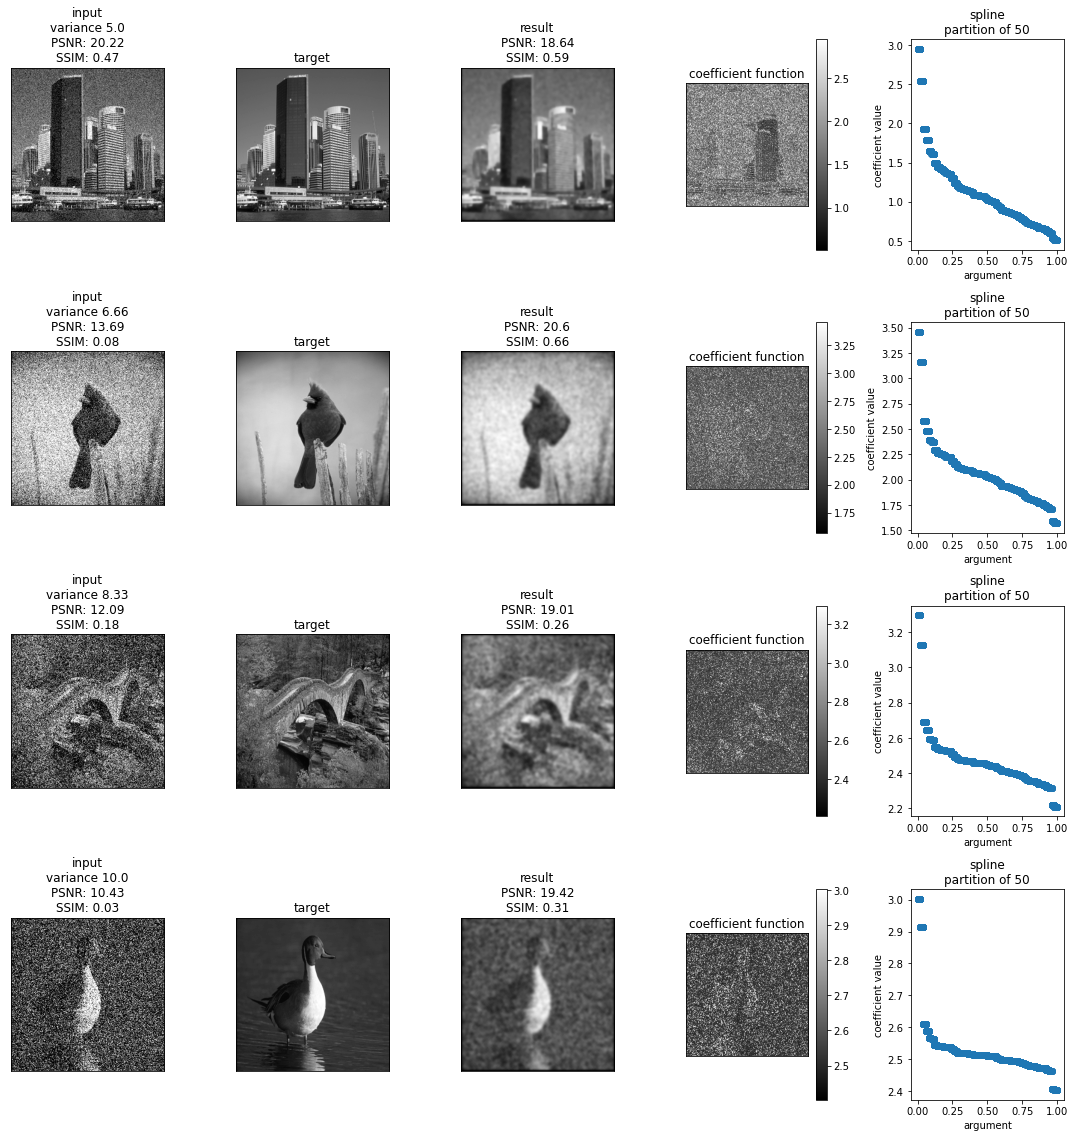

In [7]:
order = 1
num_classes = 50
model = get_model("decreasing",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
model.load_weights(f"./checkpoints/dec_{typ}_{num_classes}")

w = np.linspace(5,10,4)
fig,axs = plt.subplots(ncols = 5,nrows = int(np.ceil(len(w))),figsize=(15,4*len(w)))
for i,m in enumerate(w):

    
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=5)
    ims = next(gen_batch_val.as_numpy_iterator())
    p = model(ims[0])
    _ = np.random.choice(len(p))


    psnr_0 = tf.image.psnr(ims[0]['input'][_],ims[1][_],1).numpy()
    ssim_0 = tf.image.ssim(ims[0]['input'][_],ims[1][_],1).numpy()
    clean = p[_]
    psnr = tf.image.psnr(ims[1][_],clean,1).numpy()
    ssim = tf.image.ssim(ims[1][_],clean,1).numpy()
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('simple_extract').output)
    spline = np.squeeze(get_lambdas(ims[0])[_])
    visualization = tf.keras.models.Model(model.input,model.get_layer('coeff_x_0').output)
    vis = np.squeeze(visualization(ims[0])[_])


    psnr_0,ssim_0 = int(100*psnr_0)/100,int(100*ssim_0)/100
    psnr,ssim = int(100*psnr)/100,int(100*ssim)/100
    
    
    axs[i,0].imshow(ims[0]['input'][_],cmap='gray')
    axs[i,0].set_title(f'input\nvariance {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(ims[1][_],cmap='gray')
    axs[i,1].set_title('target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(clean,cmap='gray')
    axs[i,2].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(vis,cmap='gray')
    axs[i,3].set_title('coefficient function')
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
    partition = np.linspace(0,1,num_classes+1)
    x,s = [],[]

    for p in range(1,len(partition)):
        xp = np.linspace(partition[p-1],partition[p],100)
        linear = spline[p-1]*np.ones(len(xp))
        s.append(np.copy(linear))
        x.append(np.copy(xp))

    s = np.concatenate(s)
    x = np.concatenate(x)
    
    
    axs[i,4].scatter(x,s)
    axs[i,4].set_xlabel("argument")
    axs[i,4].set_ylabel("coefficient value")
    axs[i,4].set_title(f"spline\npartition of {num_classes}")
    
plt.tight_layout()
plt.show()

# Comparing against Perona Malik

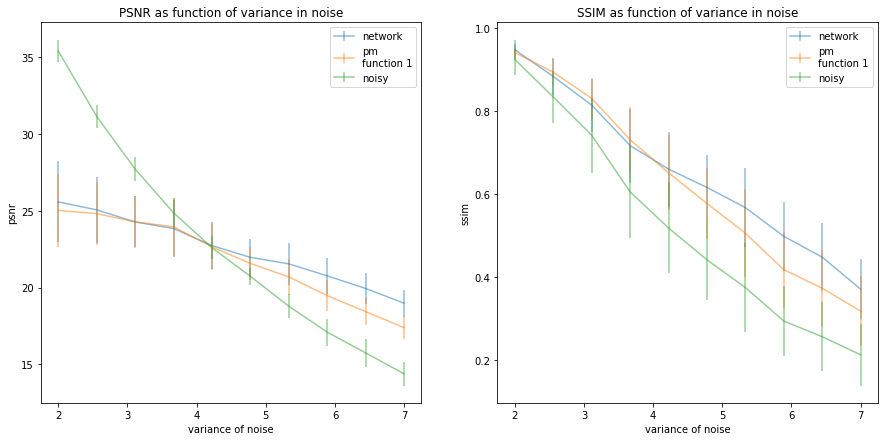

In [17]:
num_classes = 50
model = get_model("decreasing",it_lim=1,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dec_{typ}_{num_classes}")

w = np.linspace(2,7,10)
psnr_nn_1,psnr_nn_s_1 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

psnr_or_1,psnr_or_s_1 = [],[]
ssim_or_1,ssim_or_s_1 = [],[]


for i,m in enumerate(w):
    gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=10)
    
    psnr_nn_1.append([])
    psnr_nn_s_1.append([])
    ssim_nn_1.append([])
    ssim_nn_s_1.append([])
    psnr_pm_1.append([])
    psnr_pm_s_1.append([])
    ssim_pm_1.append([])
    ssim_pm_s_1.append([])
    psnr_or_1.append([])
    psnr_or_s_1.append([])
    ssim_or_1.append([])
    ssim_or_s_1.append([])
    
    for it in range(10):
        ims = next(gen_batch_val.as_numpy_iterator())

        res = model(ims[0])
        psnr = tf.image.psnr(res,ims[1],1).numpy()
        ssim = tf.image.ssim(res,ims[1],1).numpy()
        psnr_nn_1[-1].append(np.copy(psnr))
        psnr_nn_s_1[-1].append(np.copy(psnr))
        ssim_nn_1[-1].append(np.copy(ssim))
        ssim_nn_s_1[-1].append(np.copy(ssim))

        pm = np.array([anisodiff(im,niter = 1) for im in ims[0]['input']])
        pm = np.asarray(pm,dtype='float32')
        psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        psnr_pm_1[-1].append(np.copy(psnr))
        psnr_pm_s_1[-1].append(np.copy(psnr))
        ssim_pm_1[-1].append(np.copy(ssim))
        ssim_pm_s_1[-1].append(np.copy(ssim))

        psnr = tf.image.psnr(ims[0]['input'],ims[1],1).numpy()
        ssim = tf.image.ssim(ims[0]['input'],ims[1],1).numpy()
        psnr_or_1[-1].append(np.copy(psnr))
        psnr_or_s_1[-1].append(np.copy(psnr))
        ssim_or_1[-1].append(np.copy(ssim))
        ssim_or_s_1[-1].append(np.copy(ssim))
        
    psnr_nn_1[-1] = np.concatenate(psnr_nn_1[-1])
    psnr_nn_s_1[-1] = np.concatenate(psnr_nn_s_1[-1])
    ssim_nn_1[-1] = np.concatenate(ssim_nn_1[-1])
    ssim_nn_s_1[-1] = np.concatenate(ssim_nn_s_1[-1])
    
    psnr_pm_1[-1] = np.concatenate(psnr_pm_1[-1])
    psnr_pm_s_1[-1] = np.concatenate(psnr_pm_s_1[-1])
    ssim_pm_1[-1] = np.concatenate(ssim_pm_1[-1])
    ssim_pm_s_1[-1] = np.concatenate(ssim_pm_s_1[-1])
    
    psnr_or_1[-1] = np.concatenate(psnr_or_1[-1])
    psnr_or_s_1[-1] = np.concatenate(psnr_or_s_1[-1])
    ssim_or_1[-1] = np.concatenate(ssim_or_1[-1])
    ssim_or_s_1[-1] = np.concatenate(ssim_or_s_1[-1])
    
    


psnr_nn_1 = np.mean(psnr_nn_1,axis=-1)
psnr_nn_s_1 = np.std(psnr_nn_s_1,axis=-1)
ssim_nn_1 = np.mean(ssim_nn_1,axis=-1)
ssim_nn_s_1 = np.std(ssim_nn_s_1,axis=-1)
psnr_pm_1 = np.mean(psnr_pm_1,axis=-1)
psnr_pm_s_1 = np.std(psnr_pm_s_1,axis=-1)
ssim_pm_1 = np.mean(ssim_pm_1,axis=-1)
ssim_pm_s_1 = np.std(ssim_pm_s_1,axis=-1)
psnr_or_1 = np.mean(psnr_or_1,axis=-1)
psnr_or_s_1 = np.std(psnr_or_s_1,axis=-1)
ssim_or_1 = np.mean(ssim_or_1,axis=-1)
ssim_or_s_1 = np.std(ssim_or_s_1,axis=-1)

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,psnr_or_1,psnr_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,ssim_or_1,ssim_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()

/tmp/ipykernel_7865/1301504080.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ims = np.array(next(gen_batch_val.as_numpy_iterator()))


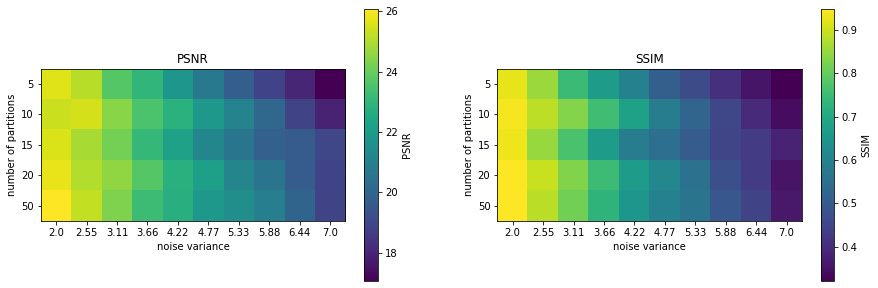

In [22]:
order = 1
w = np.linspace(2,7,10)
w = np.asarray(100*w,dtype='int')/100
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/dec_{typ}_*.index")])


hist_psnr,hist_ssim = [],[]

for num_classes in ncl:

    psnr_nn_1,ssim_nn_1 = [],[]
    model = get_model("decreasing",it_lim=1,image_size=image_size,num_classes = num_classes,order=order)
    for i,m in enumerate(w):
        
        model.load_weights(f"./checkpoints/dec_{typ}_{num_classes}")
        gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=10)
        
        psnr_nn_1.append([])
        ssim_nn_1.append([])
        for it in range(10):
            ims = np.array(next(gen_batch_val.as_numpy_iterator()))

            res = model(ims[0])
            res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
            psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
            ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
            psnr_nn_1[-1].append(psnr)
            ssim_nn_1[-1].append(ssim)
            
        psnr_nn_1[-1] = np.mean(psnr_nn_1[-1])
        ssim_nn_1[-1] = np.mean(ssim_nn_1[-1])


    hist_psnr.append(np.copy(psnr_nn_1))
    hist_ssim.append(np.copy(ssim_nn_1))
    

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(hist_psnr)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('PSNR')
plt.colorbar(label='PSNR')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.subplot(122)
plt.imshow(hist_ssim)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('SSIM')
plt.colorbar(label='SSIM')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.show()

# Analizing functions for coefficients

In [23]:
order = 1
w = np.linspace(2,10,20)
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/dec_{typ}_*.index")])
xR,R = [],[]

for num_classes in ncl:
    model = get_model("decreasing",it_lim=10,image_size=image_size,num_classes = num_classes)
    model.load_weights(f"./checkpoints/dec_{typ}_{num_classes}")
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('simple_extract').output)
    
    R.append([])
    xR.append([])
    for i,m in enumerate(w):


        gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=10)
        
        spline = []
        for it in range(10):
        
            ims = next(gen_batch_val.as_numpy_iterator())
            spline.append(np.squeeze(get_lambdas(ims[0])))
        
        spline = np.concatenate(spline,axis=0)
        spline = np.mean(spline,axis=0)

        partition = np.linspace(0,1,num_classes+1)
        x,s = [],[]


        for p in range(1,len(partition)):
            xp = np.linspace(partition[p-1],partition[p],100)
            linear = spline[p-1]*np.ones(len(xp))
            s.append(np.copy(linear))
            x.append(np.copy(xp))

        s = np.concatenate(s)
        x = np.concatenate(x)
    
    
        R[-1].append(np.copy(s))
        xR[-1].append(np.copy(x))

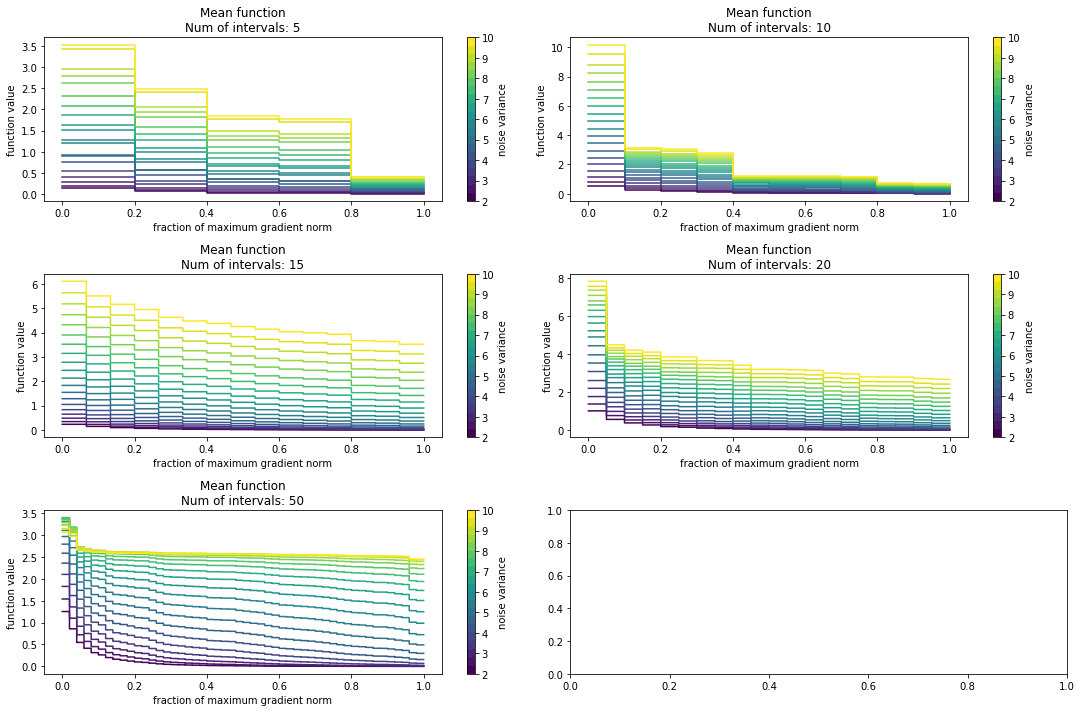

In [24]:
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols = 2,nrows = 3,figsize=(15,10))

for col in range(len(R)):
        
    if len(R[col]) == 0:
        continue

    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, len(R[col])))
    newcmp = ListedColormap(colors)

    for i in range(len(R[col])):

        #m,s = R[col][i].T

        #axs[col].errorbar(np.arange(len(m))/ncl[col],m,s,color=colors[i])
        axs[col//2,col%2].plot(xR[col][i],R[col][i],color=colors[i])

    axs[col//2,col%2].set_title(f"Mean function\nNum of intervals: {ncl[col]}")
    axs[col//2,col%2].set_xlabel("fraction of maximum gradient norm")
    axs[col//2,col%2].set_ylabel("function value")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[col//2,col%2],label='noise variance')

plt.tight_layout()        
plt.show()

# Plot the model

In [5]:
model = get_model("decreasing",it_lim=1,image_size=image_size,num_classes = 5)

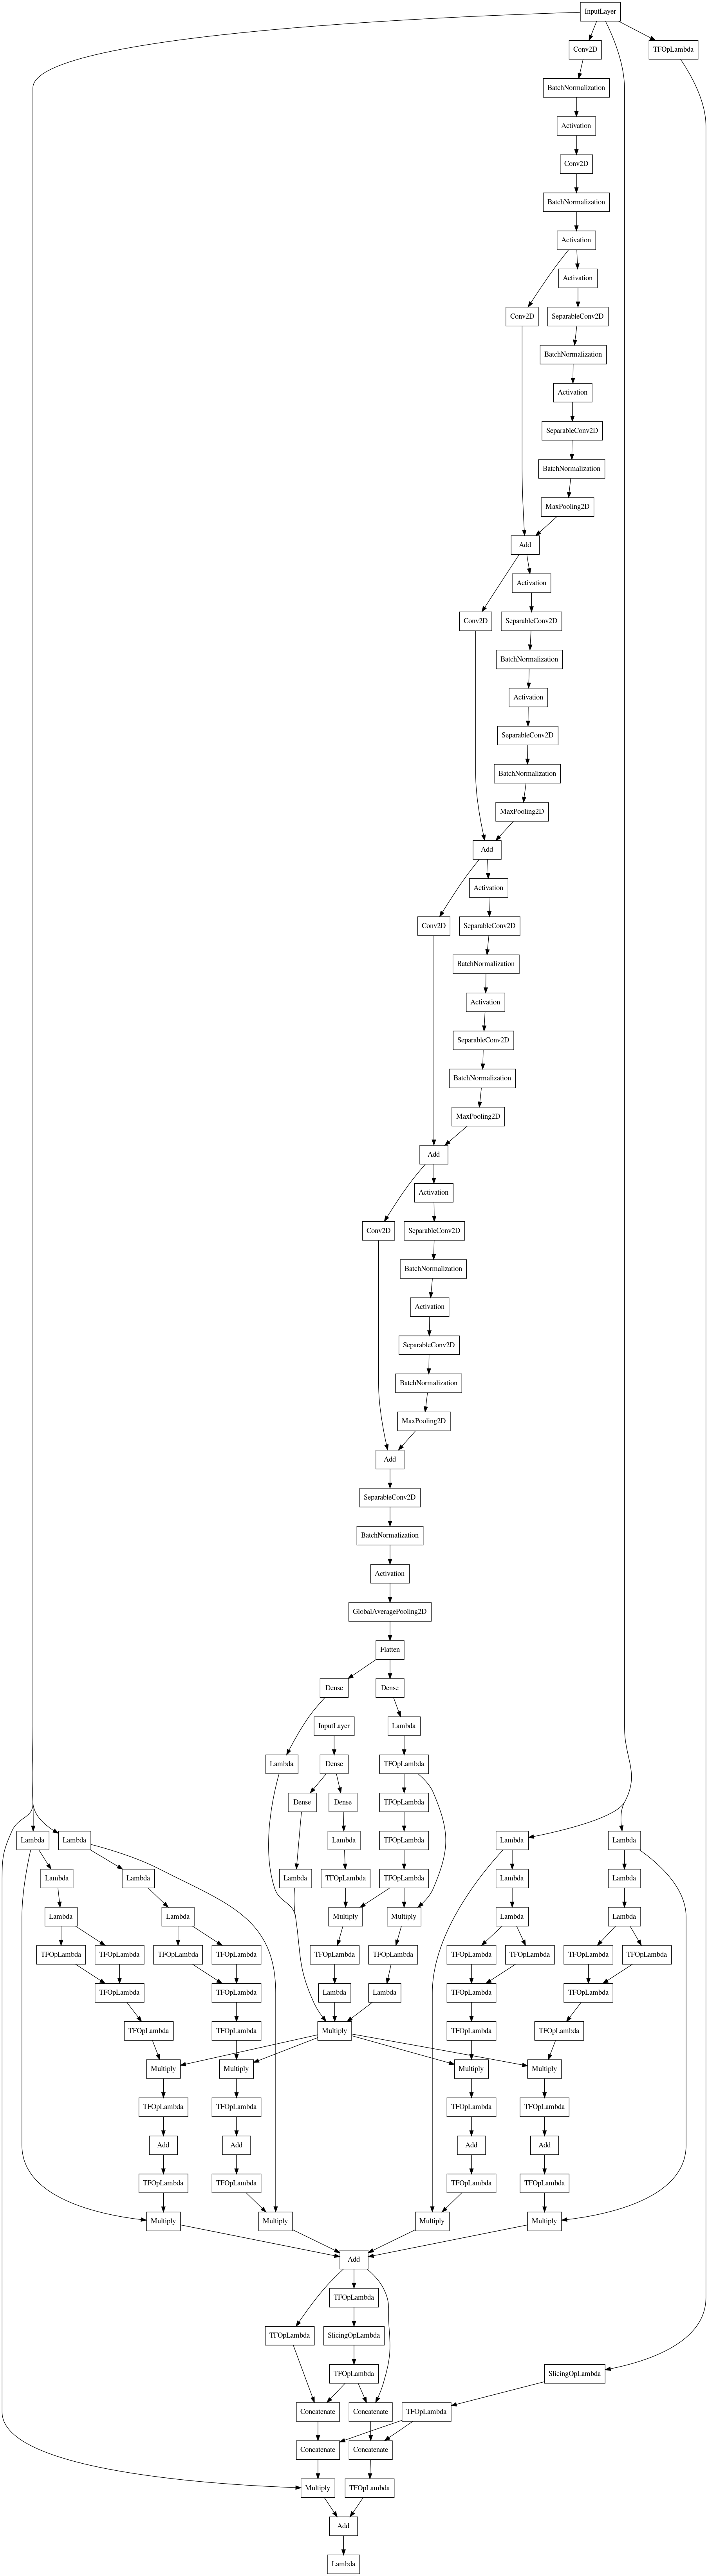

In [6]:
tf.keras.utils.plot_model(model,
    to_file="decresing.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,)